In [35]:
from plotnine import ggplot, aes, geom_point, labs, facet_wrap, geom_vline, theme_minimal, theme, element_text, geom_errorbarh
import pandas as pd
import numpy as np

In [36]:
df_detailed   = pd.read_csv('../acc_rate_csvs/detailed.csv')
df_detailed['dataset'] = 'detailed'
df_systematic = pd.read_csv('../acc_rate_csvs/systematic.csv')
df_systematic['dataset'] = 'systematic'
df_epigenomic = pd.read_csv('../acc_rate_csvs/epigenomic.csv')
df_epigenomic['dataset'] = 'epigenomic'
df = pd.concat([df_detailed, df_systematic, df_epigenomic])

avg_df = df.groupby(['dataset', 'method', 'feature engineer']).agg(
    median_acc=('acc', 'median'),
    q25_acc=('acc', lambda x: np.percentile(x, 25)),
    q75_acc=('acc', lambda x: np.percentile(x, 75))
).reset_index()


In [37]:
acc_compare_df = avg_df.copy()
acc_compare_df['lower_bound'] = acc_compare_df['q25_acc']
acc_compare_df['upper_bound'] = acc_compare_df['q75_acc']
acc_compare_df['method'] = pd.Categorical(acc_compare_df['method'], 
                                          categories=['BIC.1', 'linear.1', 'linear.2', 'linear.4', 'linear.117', 'mmit.1', 'mmit.2', 'mmit.4', 'mlp.1', 'mlp.2', 'mlp.4', 'mlp.117'], ordered=True)

C:\Users\Tung\AppData\Local\Temp\ipykernel_12836\288073661.py:17: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
C:\Users\Tung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\plotnine\scales\scales.py:48: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



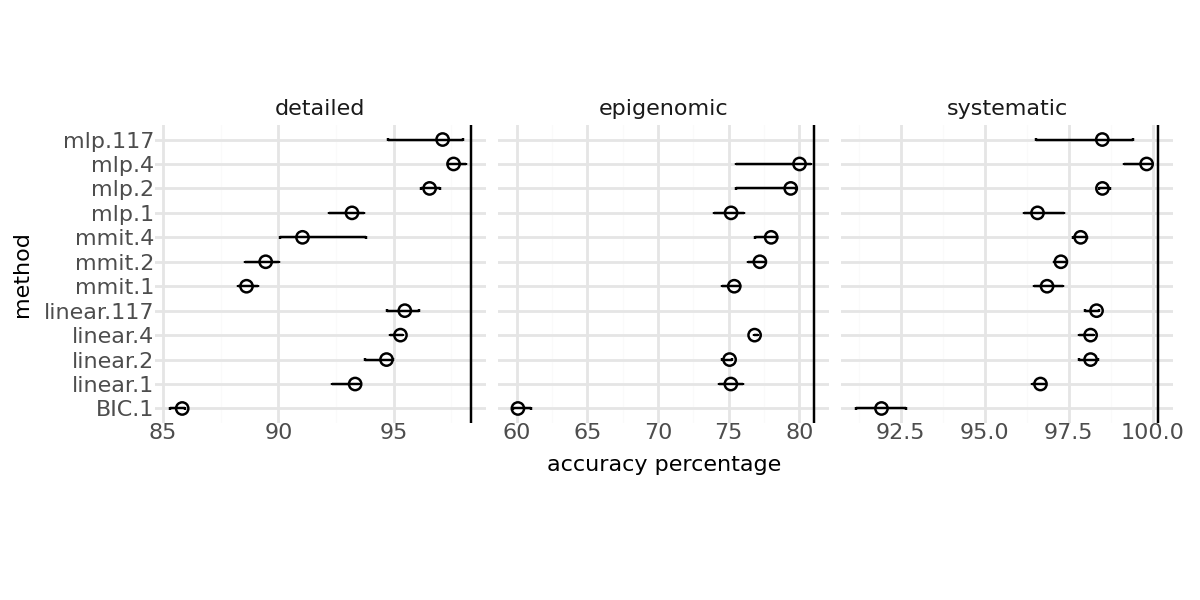

In [38]:
max_acc_per_dataset = acc_compare_df.groupby('dataset')['upper_bound'].max().reset_index()
max_acc_per_dataset.loc[:, 'upper_bound'] += 0.2

plot_combined = (ggplot(acc_compare_df, aes(x='median_acc', y='method')) +
                 geom_point(shape="o", size=2, fill="white") +
                 geom_errorbarh(aes(xmin='lower_bound', xmax='upper_bound'), height=0.1) +
                 labs(x="accuracy percentage",
                      y="method") +
                 facet_wrap('~dataset', ncol=acc_compare_df['dataset'].nunique(), scales='free_x') +
                 theme_minimal() +
                 theme(legend_position='bottom', text=element_text(size=8)) +
                 theme(aspect_ratio=0.9) +
                 geom_vline(data=max_acc_per_dataset, mapping=aes(xintercept='upper_bound'), color='black') + 
                 theme(figure_size=(6, 3))
                 )

print(plot_combined)

In [39]:
# plot_combined.save("acc_compare.pdf")
# plot_combined.save("acc_compare.jpg")